# Analyse av reelle datasett - elektrisitet

- Data hentet fra https://www.ssb.no/statbank/table/14091 (enhet: mWh)
- Mer statistikk om strømforbruk tilgjengelig i https://www.ssb.no/statbank/table/08307
- Nettoforbruk etter fylke: https://www.ssb.no/statbank/table/08313
- Kan bruke også data for temperatur for å sammenligne de ulike datasettene
  Værdata i så fall fra https://www.met.no/frie-meteorologiske-data/frie-meteorologiske-data
  Sannsynligvis https://klimaservicesenter.no (https://seklima.met.no)

## Mål

- Sammenligne ulike kilder (vann, vind, sol, varme)
- Eksport vs import over tid
- Nettap delt på strømforbruk for å se effektivitet over tid (pf?)
- Forbruk mellom ulike næringer over tid
- Forbruk i husholdninger sammenlignet med temperatur og nedbør

---

- Bruke regresjon

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm
from datetime import timedelta, datetime

## Laste data

In [3]:
df = pd.read_csv("elektrisitet.csv", delimiter=";", encoding="latin1")
df["Elektrisk kraft"] = df["Elektrisk kraft"].replace("..", np.nan)
df = df.pivot_table(index="måned", values="Elektrisk kraft", columns="produksjon og forbruk", aggfunc="first")
df.reset_index(inplace=True)

df[df.columns[1:]] = df[df.columns[1:]].apply(pd.to_numeric)

df["måned"] = pd.to_datetime(df["måned"], format="%YM%m")

start_date = df["måned"].iat[0]
df.insert(1, "month_number", (df["måned"].dt.year - start_date.year) * 12 + df["måned"].dt.month - start_date.month)

In [4]:
def get_month(month):
    # days = month * 30.44 # Approximate days in month
    # return first_month + timedelta(days=days)
    # Does not need any more precision
    year = start_date.year + (start_date.month - 1 + int(month)) // 12
    month = (start_date.month - 1 + int(month)) % 12 + 1
    return datetime(year, month, 1)

In [4]:
df

produksjon og forbruk,måned,month_number,1 Total produksjon av elektrisk kraft,1.1 Produksjon av vannkraft,1.2 Produksjon av vindkraft,1.3 Produksjon av solkraft,1.4 Produksjon av varmekraft,2 Import,3 Eksport,4 Bruttoforbruk av elektrisk kraft,...,"7.231 Forbruk i produksjon av papirmasse, papir og papp",7.232 Forbruk i produksjon av kjemiske råvarer,"7.233 Forbruk i produksjon av jern, stål og ferro",7.234 Forbruk i produksjon av aluminium og andre metaller,7.24 Forbruk i industri utenom kraftintensiv industri,"7.25 Forbruk i kraftforsyning, VAR, bygg og anlegg",7.3 Forbruk i tertiærnæringer,7.4 Forbruk i husholdninger,7.41 Forbruk i boliger,7.42 Forbruk i hytter og fritidshus
0,1993-01-01,0,11718176,11673067,NaN,NaN,45109,42135,459820,11300491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-02-01,1,10675869,10636402,NaN,NaN,39467,35271,466053,10245087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-03-01,2,11406111,11377918,NaN,NaN,28193,35198,564604,10876705,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-04-01,3,9464337,9426997,NaN,NaN,37340,40041,660249,8844129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-05-01,4,8339679,8292378,NaN,NaN,47301,25683,599141,7766221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,2024-10-01,381,12878212,11283463,1383865.0,7779.0,203105,1281038,2697042,11462208,...,277228.0,558334.0,421039.0,1861821.0,678587.0,346229.0,2147978.0,3235406.0,3050830.0,184576.0
382,2024-11-01,382,14743252,13217189,1343629.0,2106.0,180328,1002181,3041763,12703670,...,282813.0,484976.0,431714.0,1803382.0,684364.0,446571.0,2448669.0,4093880.0,3854840.0,239040.0
383,2024-12-01,383,15846494,13923035,1760253.0,715.0,162490,1103533,3150466,13799561,...,276094.0,546544.0,386679.0,1844099.0,652509.0,515496.0,2655950.0,4750894.0,4445889.0,305005.0
384,2025-01-01,384,17367736,15778874,1414521.0,762.0,173579,849279,3464021,14752994,...,278323.0,594150.0,405640.0,1866759.0,734784.0,572717.0,2829194.0,5215771.0,4889227.0,326544.0


<Axes: >

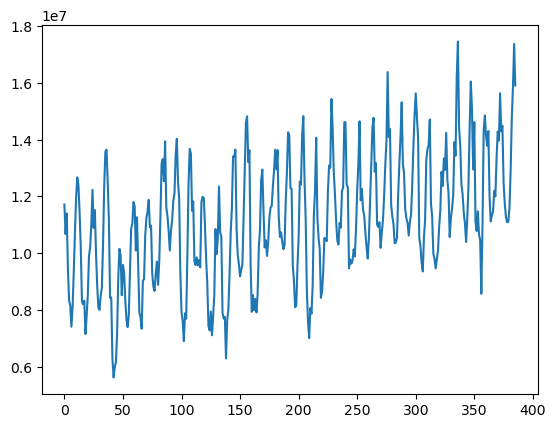

In [210]:
df["1 Total produksjon av elektrisk kraft"].plot()

## Vindkraft

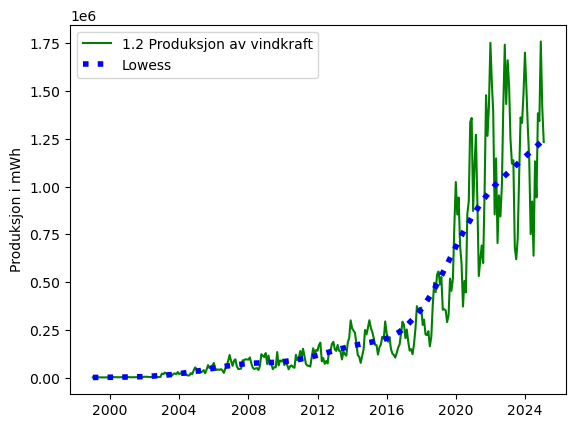

In [6]:
wind = df["1.2 Produksjon av vindkraft"]

wind_lowess = sm.nonparametric.lowess(wind, df.index, frac=0.2, return_sorted=False)
wind_lowess = pd.Series(wind_lowess, df.index, name="Lowess")

#wind_smoothed = wind.rolling(window=10).mean().rename("Glidende gjennomsnitt")

plt.plot(df["måned"], wind, label=wind.name, color="g")
#plt.plot(df["måned"], wind_smoothed, label=wind_smoothed.name, linestyle=":", linewidth=4, color="r")
plt.plot(df["måned"], wind_lowess, label=wind_lowess.name, linestyle=":", linewidth=4, color="b")

plt.ylabel("Produksjon i mWh")

plt.legend()

### Regresjonsanalyse

Bruker regresjon for å finne en modell for utviklingen av vindkraftproduksjon i norge.

In [170]:
# Fjerne all data før første måling (alt før er NaN)
first = wind.first_valid_index()
ys = wind.loc[first:]
xs = df["month_number"].loc[first:]
xs_datetime = df["måned"].loc[first:]

#### Eksponentiell vekst

Bruker følgende modell:

$$
f \left( x \right) = a \cdot b ^{t}
$$

---

##### Startverdier

- $a$ er den første verdien i datasettet.
- $b$ er et tall slik at $b > 1$, ellers hadde funksjonen vært avtakende.

In [ ]:
def model_exp(t, a, b):
    return a * b ** t

In [175]:
a = ys.iat[0]
b = 1.1
coeffs_exp, _ = curve_fit(model_exp, xs, ys, p0=[a, b])

#### Logistisk vekst

Bruker følgende modell:

$$
f \left( t \right) = \frac{C}{1 + a \cdot e^{-bt}}
$$

---

##### Startverdier

- $C$ er den høyeste av $y$-verdiene.
- $a$ bestemmer startverdien, og er derfor $\dfrac{C}{y_{0}}-1$. Dette er fordi når $t=0$, vil $e^{-bt}$ være lik $1$.
- $b$ er en verdi slik at $b > 0$, da det ellers ikke blir noen vekst.

In [178]:
def model_logistic(t, a, b, C):
    return C / (1 + a * np.exp(-b * t))

In [188]:
C = ys.max()
a = C / ys.iat[0] - 1
b = 0.01
coeffs_logistic, _ = curve_fit(model_logistic, xs, ys, p0=[a, b, C])

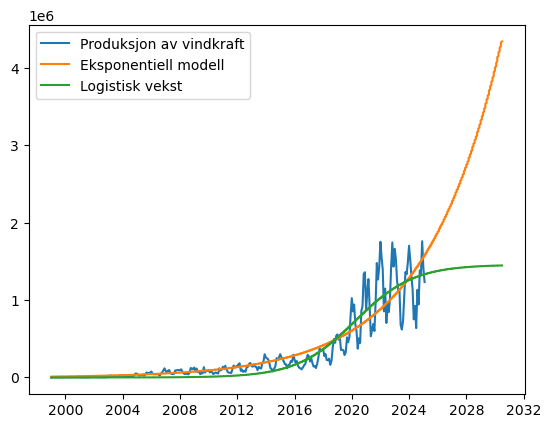

In [208]:
xs_model = np.linspace(first, 450, 2000)
ys_exp = model_exp(xs_model, *coeffs_exp)
ys_logistic = model_logistic(xs_model, *coeffs_logistic)
xs_model = [get_month(m) for m in xs_model]

plt.plot(xs_datetime, ys, label="Produksjon av vindkraft")
plt.plot(xs_model, ys_exp, label="Eksponentiell modell")
plt.plot(xs_model, ys_logistic, label="Logistisk vekst")

plt.legend()